In [1]:
import traceback
import ujson
import time
import pendulum
import pandas as pd
import numpy as np
import re
from unicodedata import normalize
from itertools import product
import time
import pickle
import matplotlib.pyplot as plt
import math

import ipdb

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 500)
pd.set_option('display.width',2000)
pd.set_option('display.max_rows', 500)

## CSVデータの読み込み

In [2]:
column_names = [
    'no',  # No
    'code',  # 全国地方公共団体コード
    'prefecture',  # 都道府県名
    'published_at',   # 公表年月日
    'infected_at',   # 感染確認年月日
    'patients_area',  # 患者居住地
    'patients_age',  # 患者年代
    'patients_sex',  # 患者性別
]

df_csv = pd.read_csv(
    './master_data/csv/yamagata_patients.csv',
    na_values= ['−'], 
    # dtype={}
    names = column_names,  # ヘッダー行が無い場合に使う
    skiprows=1
)

## 使用しないフィールドを削除
# del df_csv['no']
del df_csv['code']
del df_csv['prefecture']
# display(df_csv.loc[
#     (df_csv.published_at.isnull()) | 
#     (df_csv.infected_at.isnull()) | 
#     (df_csv.patients_area.isnull()) | 
#     (df_csv.patients_age.isnull()) |
#     (df_csv.patients_sex.isnull())
# ])
#df_csv = df_csv.dropna(how='any')
print('無効データ')
display(df_csv.loc[
    (df_csv.published_at == '欠番') | 
    (df_csv.patients_area.isnull()) | 
    (df_csv.patients_age.isnull()) |
    (df_csv.patients_sex.isnull())
])
df_csv = df_csv.dropna(subset=['patients_area', 'patients_age'])


# -- 発表日と感染確認日を日付型に変換
df_csv['published_at'] = pd.to_datetime(
    df_csv['published_at'], 
    format='%Y/%m/%d', 
    infer_datetime_format=True
)
df_csv['infected_at'] = pd.to_datetime(
    df_csv['infected_at'], 
    format='%Y/%m/%d', 
    infer_datetime_format=True
)

# -- エリア設定
shonai = ['鶴岡市', '酒田市', '庄内町', '三川町', '遊佐町']
df_csv.loc[df_csv['patients_area'].isin(shonai), 'area'] = '庄内'
murayama = ['山形市', '寒河江市', '天童市', '東根市', '上山市', '山辺町', '中山町', '尾花沢市', '村山市', '朝日町', '大江町', '河北町', '大石田町', '西川町']
df_csv.loc[df_csv['patients_area'].isin(murayama), 'area'] = '村山'    
mogami = ['鮭川村', '新庄市', '最上町', '金山町', '真室川町', '戸沢村', '大蔵村', '舟形町']
df_csv.loc[df_csv['patients_area'].isin(mogami), 'area'] = '最上'    
okitama = ['小国町', '白鷹町', '飯豊町', '長井市', '南陽市', '川西町', '高畠町', '米沢市']
df_csv.loc[df_csv['patients_area'].isin(okitama), 'area'] = '置賜'    
# -- 確認
print('有効データ')
pd.set_option('display.max_rows', 500)
# df_csv.loc[df_csv.no == 1815]
df_csv

無効データ


,no,published_at,infected_at,patients_area,patients_age,patients_sex
365,366,2020/12/27,2020/12/26,NaN,NaN,NaN
656,657,欠番,NaN,NaN,NaN,NaN
657,658,欠番,NaN,NaN,NaN,NaN
658,659,欠番,NaN,NaN,NaN,NaN
659,660,欠番,NaN,NaN,NaN,NaN
660,661,欠番,NaN,NaN,NaN,NaN
1649,1650,欠番,NaN,NaN,NaN,NaN
3018,3019,欠番,NaN,NaN,NaN,NaN
3686,3687,欠番,NaN,NaN,NaN,NaN
5771,5772,欠番,NaN,NaN,NaN,NaN


有効データ


,no,published_at,infected_at,patients_area,patients_age,patients_sex,area
0,1,2020-03-31,2020-03-31,神奈川県,20代,女性,NaN
1,2,2020-04-01,2020-03-31,上山市,60代,男性,村山
2,3,2020-04-02,2020-04-01,新庄市,60代,男性,最上
3,4,2020-04-04,2020-04-03,新庄市,60代,女性,最上
4,5,2020-04-04,2020-04-03,新庄市,30代,女性,最上
...,...,...,...,...,...,...,...
9781,9782,2022-02-18,2022-02-17,庄内町,20代,女性,庄内
9782,9783,2022-02-18,2022-02-17,庄内町,30代,男性,庄内
9783,9784,2022-02-18,2022-02-17,庄内町,30代,女性,庄内
9784,9785,2022-02-18,2022-02-17,庄内町,50代,女性,庄内


### Init

In [3]:
# plt.rcParams["font.family"] = "IPAGothic"
plt.rcParams["font.family"] = "TakaoGothic"
# plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
# plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)

### 直近20日  地方別7日間移動合計

In [4]:
# -- init
df_ts = pd.DataFrame()
df_ts_shonai = pd.DataFrame()  # 庄内用
df_ts_murayama = pd.DataFrame()  # 村山用
df_ts_okitama = pd.DataFrame()  # 置賜用
df_ts_mogami = pd.DataFrame()  # 最上

df_ts_tsuruoka = pd.DataFrame()  # 鶴岡市
df_ts_sakata = pd.DataFrame()
df_ts_mikawa = pd.DataFrame()
df_ts_shonaimachi = pd.DataFrame()
df_ts_yuza = pd.DataFrame()

today = pendulum.now(tz='Asia/Tokyo')
range_days = 7 # 移動合計のレンジを指定
term_days = 21 # 期間

def movingSum(df, cities, area, target):
    df.loc[df['patients_area'].isin(cities), 'area'] = area
    df = df.dropna(how='any').reset_index(drop=True)
    df['日付'] = target
    sum_infect = df['7日間の感染者数移動合計'].sum()
    
    ret1 = [{
        '日付': target, 
        '7日間の感染者数移動合計': sum_infect
    }]
    ret2 = df[['7日間の感染者数移動合計', 'area', '日付']]
    return (ret1, ret2)


def locByCity(df, city, target):
    df_tmp = df.loc[df_sum['patients_area'] == city]
    if len(df_tmp):
        ret = [{
            '日付': target, 
            '7日間の感染者数移動合計': df_tmp.iloc[0]['7日間の感染者数移動合計']
        }]
    else:
        ret = [{
            '日付': target, 
            '7日間の感染者数移動合計': 0
        }]
    return ret


def calcRt(target, minus_1wk, df):
    tagt_value = df.loc[df['日付'] == target]['7日間の感染者数移動合計'][0]
    past_value = df.loc[df['日付'] == minus_1wk]['7日間の感染者数移動合計'][0]
    
    # 実効再生産数=（直近7日間の新規陽性者数／その前の7日間の新規陽性者数）^（平均世代時間／報告間隔）
    # 平均世代時間とは、「感染源の感染から2次感染者の感染までに要する平均時間」を指す。
    # 東洋経済オンラインでの計算では、西浦教授のアドバイスに沿って5（日）をデータに使っている。報告間隔は7（日）だ
    if past_value == 0:
        rt = 0
    else:
        rt = (tagt_value / past_value) ** (5 / 7)
    
    df.loc[df['日付'] == target, '実効再生産数'] = round(rt, 2)
    
    return df

    
for i in range(term_days, -1, -1):
    target = today.subtract(days=i)
    minus_1wk_str = target.subtract(days=range_days).strftime('%Y-%m-%d')
    minus_1wk_str_md = target.subtract(days=range_days).strftime('%m-%d')
    target_str_ymd = target.strftime('%Y-%m-%d')
    target_str_md = target.strftime('%m-%d')
    df_recent = df_csv.loc[
        (df_csv.published_at>minus_1wk_str) & 
        (df_csv.published_at<=target_str_ymd)
    ].copy() 
    sr_sum = df_recent.patients_area.value_counts()
    df_sum = sr_sum.to_frame().reset_index()
    df_sum.columns = ['patients_area', '7日間の感染者数移動合計']
    # -- 庄内
    res1, res2 = movingSum(df_sum, shonai, '庄内', target_str_md)
    # print(res1)
    df_ts_shonai = df_ts_shonai.append(res1)
    df_ts = df_ts.append(res2)
    # -- 村山
    res1, res2 = movingSum(df_sum, murayama, '村山', target_str_md)
    df_ts_murayama = df_ts_murayama.append(res1)
    df_ts = df_ts.append(res2) 
    # -- 置賜
    res1, res2 = movingSum(df_sum, okitama, '置賜', target_str_md)
    df_ts_okitama = df_ts_okitama.append(res1)
    df_ts = df_ts.append(res2) 
    # -- 最上
    res1, res2 = movingSum(df_sum, mogami, '最上', target_str_md)
    df_ts_mogami = df_ts_mogami.append(res1)
    df_ts = df_ts.append(res2)

    # -- 各市町村別
    df_ts_tsuruoka = df_ts_tsuruoka.append(locByCity(df_sum, '鶴岡市', target_str_md))
    df_ts_sakata = df_ts_sakata.append(locByCity(df_sum, '酒田市', target_str_md))
    df_ts_mikawa = df_ts_mikawa.append(locByCity(df_sum, '三川町', target_str_md))
    df_ts_shonaimachi = df_ts_shonaimachi.append(locByCity(df_sum, '庄内町', target_str_md))
    df_ts_yuza = df_ts_yuza.append(locByCity(df_sum, '遊佐町', target_str_md))
    
    # -- Rt計算
    if term_days - 8  > i:  # 8日目移行は簡易Rtが計算できる
        df_ts_tsuruoka = calcRt(target_str_md, minus_1wk_str_md, df_ts_tsuruoka)
        df_ts_sakata = calcRt(target_str_md, minus_1wk_str_md, df_ts_sakata)
        df_ts_mikawa = calcRt(target_str_md, minus_1wk_str_md, df_ts_mikawa)
        df_ts_shonaimachi = calcRt(target_str_md, minus_1wk_str_md, df_ts_shonaimachi)
        df_ts_yuza = calcRt(target_str_md, minus_1wk_str_md, df_ts_yuza)
        # # -- エリア毎
        df_ts_shonai = calcRt(target_str_md, minus_1wk_str_md, df_ts_shonai)
        df_ts_murayama = calcRt(target_str_md, minus_1wk_str_md, df_ts_murayama)
        df_ts_okitama = calcRt(target_str_md, minus_1wk_str_md, df_ts_okitama)
        df_ts_mogami = calcRt(target_str_md, minus_1wk_str_md, df_ts_mogami)

            
df_ts_shonai = df_ts_shonai.reset_index(drop=True)
df_ts_murayama = df_ts_murayama.reset_index(drop=True)
df_ts_okitama = df_ts_okitama.reset_index(drop=True)
df_ts_mogami = df_ts_mogami.reset_index(drop=True)

df_ts_tsuruoka = df_ts_tsuruoka.reset_index(drop=True)  # 鶴岡市
df_ts_sakata = df_ts_sakata.reset_index(drop=True)
df_ts_mikawa = df_ts_mikawa.reset_index(drop=True)
df_ts_shonaimachi = df_ts_shonaimachi.reset_index(drop=True)
df_ts_yuza = df_ts_yuza.reset_index(drop=True)

/tmp/ipykernel_290210/4181890895.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df_ts_shonai['日付'],df_ts_shonai['実効再生産数'],'bo-', color='red', label=f'庄内地方')
/tmp/ipykernel_290210/4181890895.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df_ts_murayama['日付'],df_ts_murayama['実効再生産数'],'bo-', color='purple', label=f'村山地方')
/tmp/ipykernel_290210/4181890895.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df_ts_okitama['日付'],df_ts_okitama['実効再生産数'],'bo-', color='green', label=f'置賜地方')
/tmp/ipykernel_290210/4181890895.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt strin

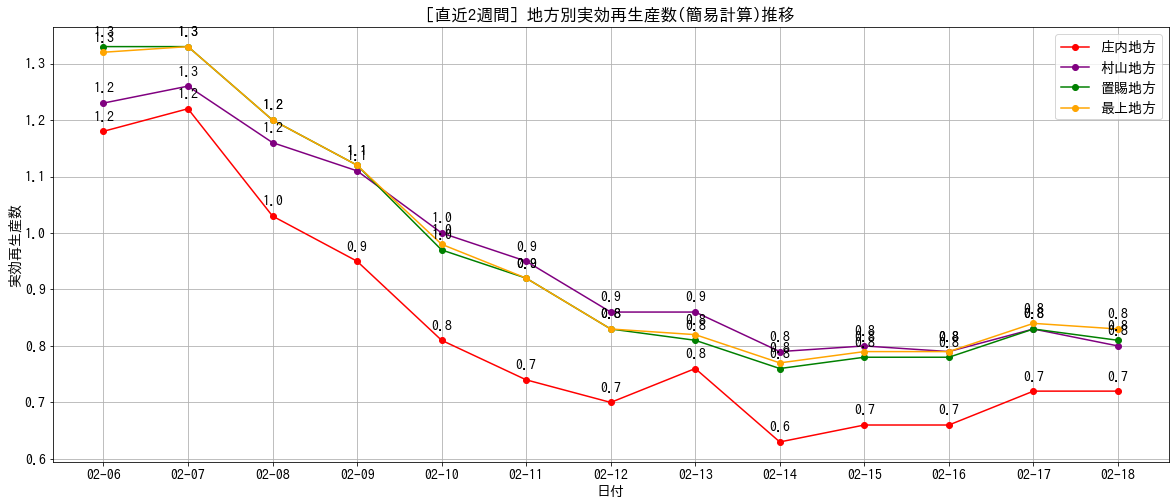

In [5]:
# rtグラフ描画

plt.rcParams["font.family"] = "TakaoGothic"
plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots()

# -- 庄内
plt.plot(df_ts_shonai['日付'],df_ts_shonai['実効再生産数'],'bo-', color='red', label=f'庄内地方')
for x,y in zip(df_ts_shonai['日付'],df_ts_shonai['実効再生産数']):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# -- 村山
plt.plot(df_ts_murayama['日付'],df_ts_murayama['実効再生産数'],'bo-', color='purple', label=f'村山地方')
for x,y in zip(df_ts_murayama['日付'],df_ts_murayama['実効再生産数']):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# -- 置賜
plt.plot(df_ts_okitama['日付'],df_ts_okitama['実効再生産数'],'bo-', color='green', label=f'置賜地方')
for x,y in zip(df_ts_okitama['日付'],df_ts_okitama['実効再生産数']):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# -- 最上
plt.plot(df_ts_mogami['日付'],df_ts_mogami['実効再生産数'],'bo-', color='orange', label=f'最上地方')
for x,y in zip(df_ts_mogami['日付'],df_ts_mogami['実効再生産数']):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
ax.set(
    title = f'[直近2週間] 地方別実効再生産数(簡易計算)推移',
    ylabel = "実効再生産数",
    xlabel = "日付"
)
plt.grid(True)
plt.legend()
plt.savefig('rt_byarea.png', dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)
plt.show()

### 庄内地方市町村単位の実効再生産数（簡易計算結果によるプロット）

/tmp/ipykernel_290210/2186112061.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df_ts_shonai['日付'],df_ts_tsuruoka['実効再生産数'],'bo-', color='blue', label=f'鶴岡市')
/tmp/ipykernel_290210/2186112061.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df_ts_sakata['日付'],df_ts_sakata['実効再生産数'],'bo-', color='red', label=f'酒田市')
/tmp/ipykernel_290210/2186112061.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df_ts_mikawa['日付'],df_ts_mikawa['実効再生産数'],'bo-', color='orange', label=f'三川町')
/tmp/ipykernel_290210/2186112061.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" 

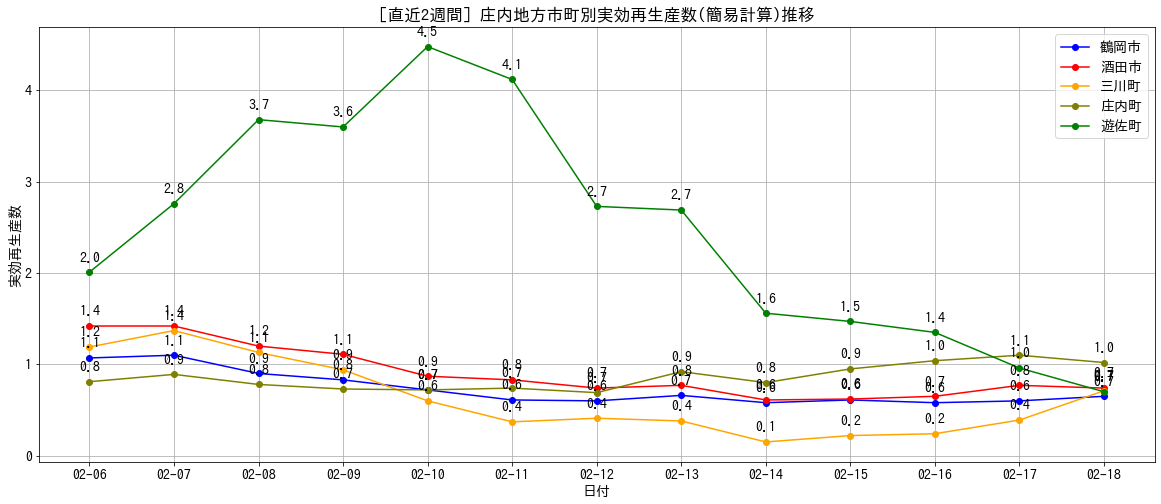

In [6]:
# rtグラフ描画

plt.rcParams["font.family"] = "TakaoGothic"
plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots()

# -- 鶴岡市
plt.plot(df_ts_shonai['日付'],df_ts_tsuruoka['実効再生産数'],'bo-', color='blue', label=f'鶴岡市')
for x,y in zip(df_ts_tsuruoka['日付'],df_ts_tsuruoka['実効再生産数']):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# -- 酒田市
plt.plot(df_ts_sakata['日付'],df_ts_sakata['実効再生産数'],'bo-', color='red', label=f'酒田市')
for x,y in zip(df_ts_sakata['日付'],df_ts_sakata['実効再生産数']):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# -- 三川町
plt.plot(df_ts_mikawa['日付'],df_ts_mikawa['実効再生産数'],'bo-', color='orange', label=f'三川町')
for x,y in zip(df_ts_mikawa['日付'],df_ts_mikawa['実効再生産数']):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# -- 庄内町
plt.plot(df_ts_shonaimachi['日付'],df_ts_shonaimachi['実効再生産数'],'bo-', color='olive', label=f'庄内町')
for x,y in zip(df_ts_shonaimachi['日付'],df_ts_shonaimachi['実効再生産数']):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# -- 遊佐町
plt.plot(df_ts_yuza['日付'],df_ts_yuza['実効再生産数'],'bo-', color='green', label=f'遊佐町')
for x,y in zip(df_ts_yuza['日付'],df_ts_yuza['実効再生産数']):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

ax.set(
    title = f'[直近2週間] 庄内地方市町別実効再生産数(簡易計算)推移',
    ylabel = "実効再生産数",
    xlabel = "日付"
)
plt.grid(True)
plt.legend()
plt.savefig('rt_byshonai.png', dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)
plt.show()

In [7]:
df_ts_tsuruoka

,日付,7日間の感染者数移動合計,実効再生産数
0,01-28,285,NaN
1,01-29,311,NaN
2,01-30,401,NaN
3,01-31,404,NaN
4,02-01,455,NaN
5,02-02,485,NaN
6,02-03,534,NaN
7,02-04,536,NaN
8,02-05,520,NaN
9,02-06,443,1.07
